# Tree-informed optimal transport of single-cell and spatial transcriptomics
Here we generate fake data consisting of paired spatial and single-cell gene expression data. We use Cassiopeia to generate a phylogenetic tree of single-cells and place them in 2D space, and from that we generate single-cell and spot-based gene expression. We then apply various approaches to map the single-cell data to spots.

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import squidpy as sq
import scanpy as sc
import seaborn as sns

import importlib
import os

file_path = os.path.join(os.getcwd(), "../src/spotr/", "space_simulator.py")
spec = importlib.util.spec_from_file_location("space_simulator", file_path)
space_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(space_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "expression_simulator.py")
spec = importlib.util.spec_from_file_location("expression_simulator", file_path)
expression_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(expression_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "visium_simulator.py")
spec = importlib.util.spec_from_file_location("visium_simulator", file_path)
visium_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(visium_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "mappers.py")
spec = importlib.util.spec_from_file_location("mappers", file_path)
mappers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mappers)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "utils.py")
spec = importlib.util.spec_from_file_location("utils", file_path)
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "scvi_utils.py")
spec = importlib.util.spec_from_file_location("scvi_utils", file_path)
scvi_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(scvi_utils)

file_path = os.path.join(os.getcwd(), "../src/scDOT/", "scdot.py")
spec = importlib.util.spec_from_file_location("scdot", file_path)
scdot = importlib.util.module_from_spec(spec)
spec.loader.exec_module(scdot)

## Generate cell lineage tree and spatial locations
Here we simply show what the simulated data look like. 

In [2]:
ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, simulated_tree = utils.simulate_data('main_clades', 'tree', seed=1)

In [4]:
spatial_simulated_adata.obsm['clade_level2_fractions']

,clade4,clade5,clade6,clade7
spot_89,0.500000,0.500000,0.000000,0.000000
spot_26,0.666667,0.333333,0.000000,0.000000
spot_27,0.666667,0.333333,0.000000,0.000000
spot_28,0.500000,0.500000,0.000000,0.000000
spot_29,0.500000,0.500000,0.000000,0.000000
...,...,...,...,...
spot_120,0.000000,0.333333,0.000000,0.666667
spot_82,0.000000,0.000000,0.250000,0.750000
spot_81,0.000000,0.000000,0.333333,0.666667
spot_78,0.000000,0.000000,0.000000,1.000000


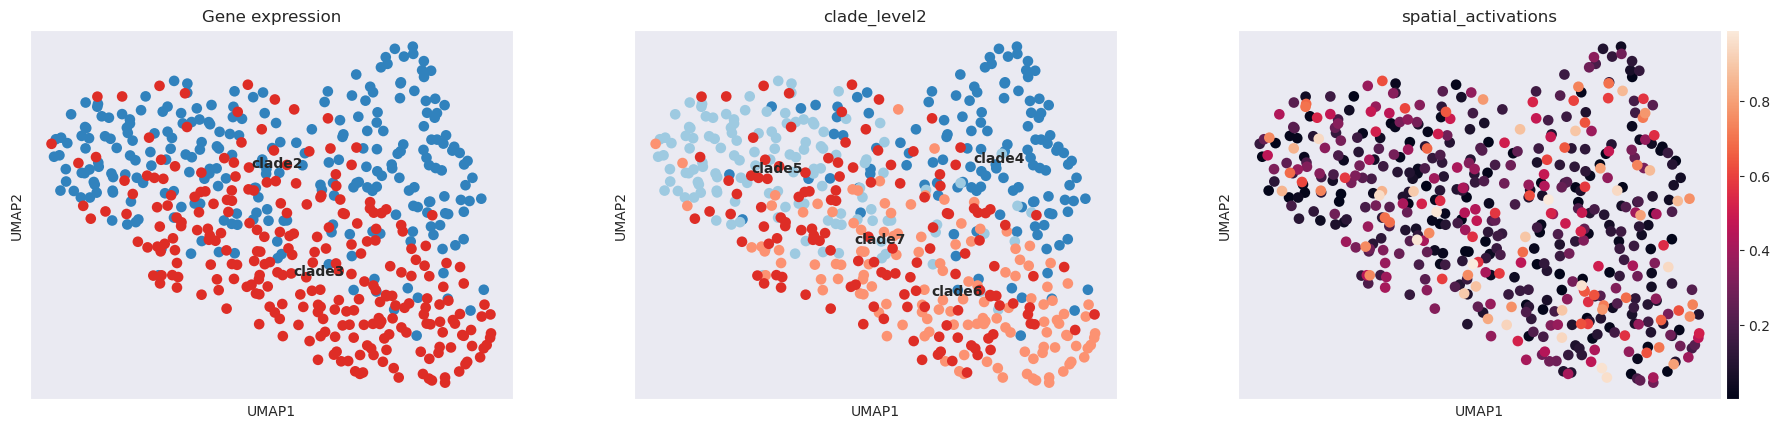

/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


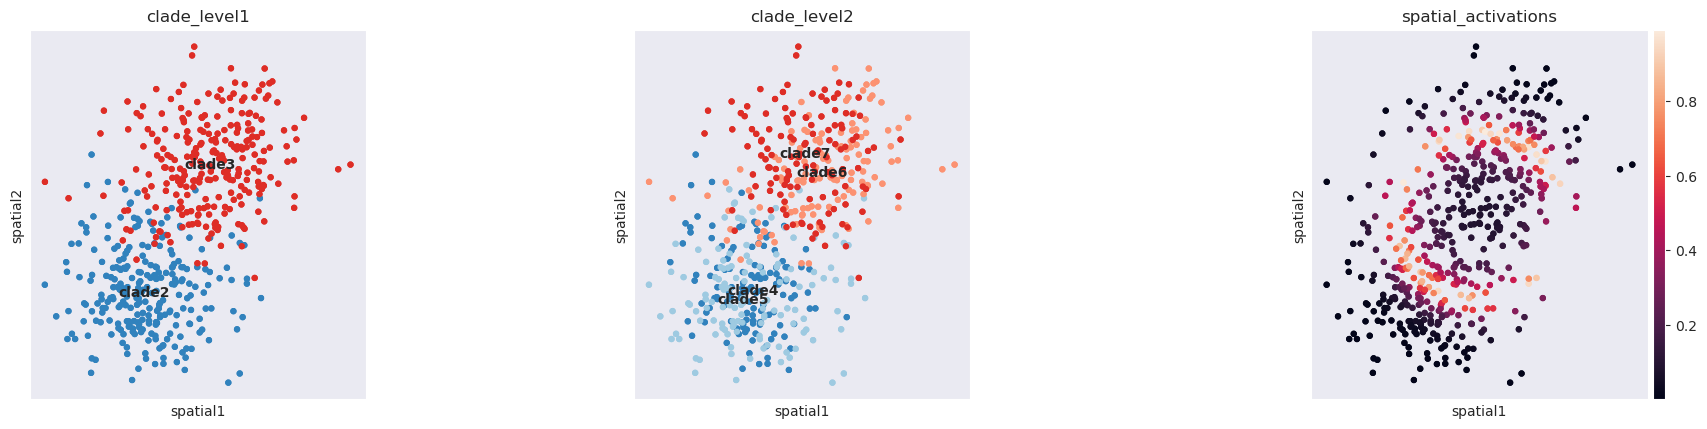

In [5]:
ss_simulated_adata.uns['clade_level1_colors'] = ['#3182bd', '#de2d26',]
ss_simulated_adata.uns['clade_level2_colors'] = ['#3182bd', '#9ecae1', '#fc9272', '#de2d26']
sc.pp.neighbors(ss_simulated_adata)
sc.tl.umap(ss_simulated_adata)
sc.pl.umap(ss_simulated_adata, color=['clade_level1', 'clade_level2', 'spatial_activations'] , title='Gene expression', legend_loc='on data')
sq.pl.spatial_scatter(ss_simulated_adata, color=['clade_level1', 'clade_level2', 'spatial_activations'], library_id='puck1',
                    size=50, shape=None, legend_loc='on data', ncols=3)

/tmp/ipykernel_231915/835272802.py:1: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  spatial_simulated_adata.uns['clade_level1_colors'] = ['#3182bd', '#de2d26',]


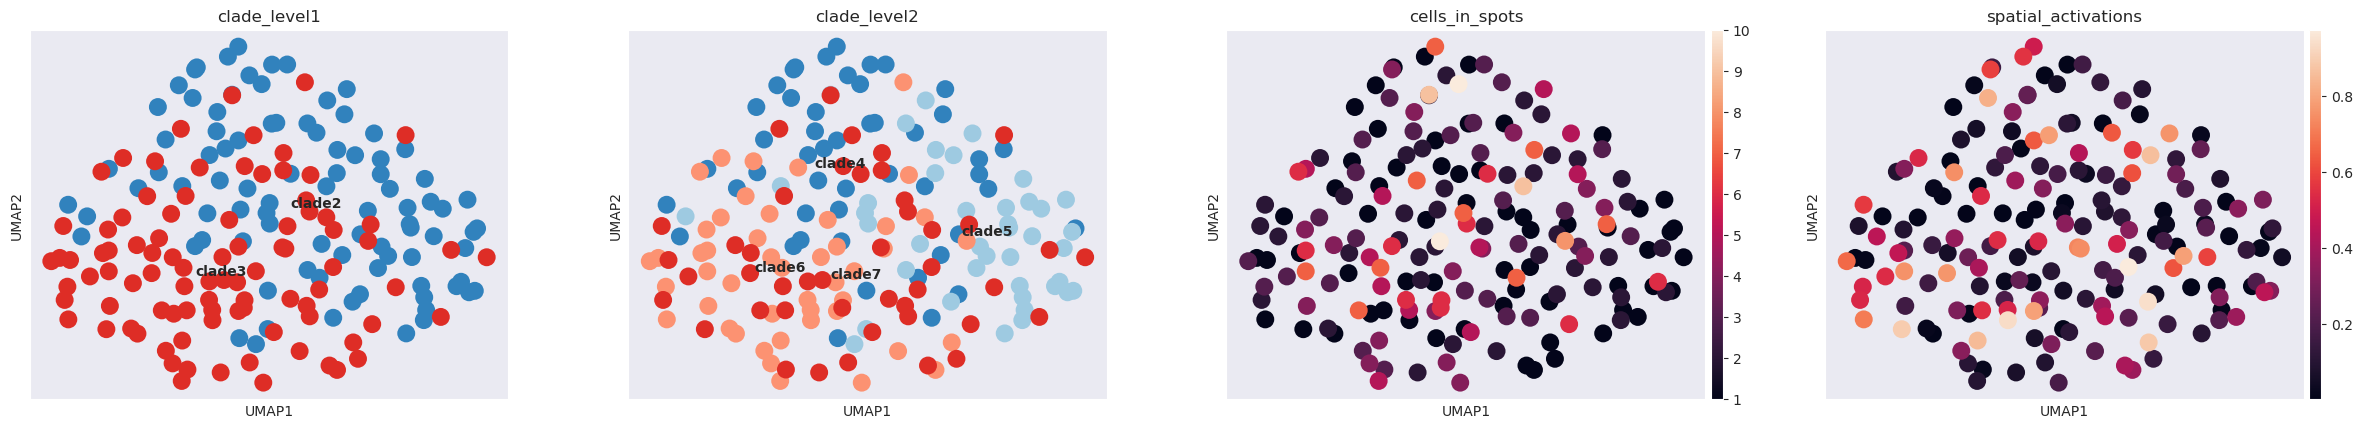

/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


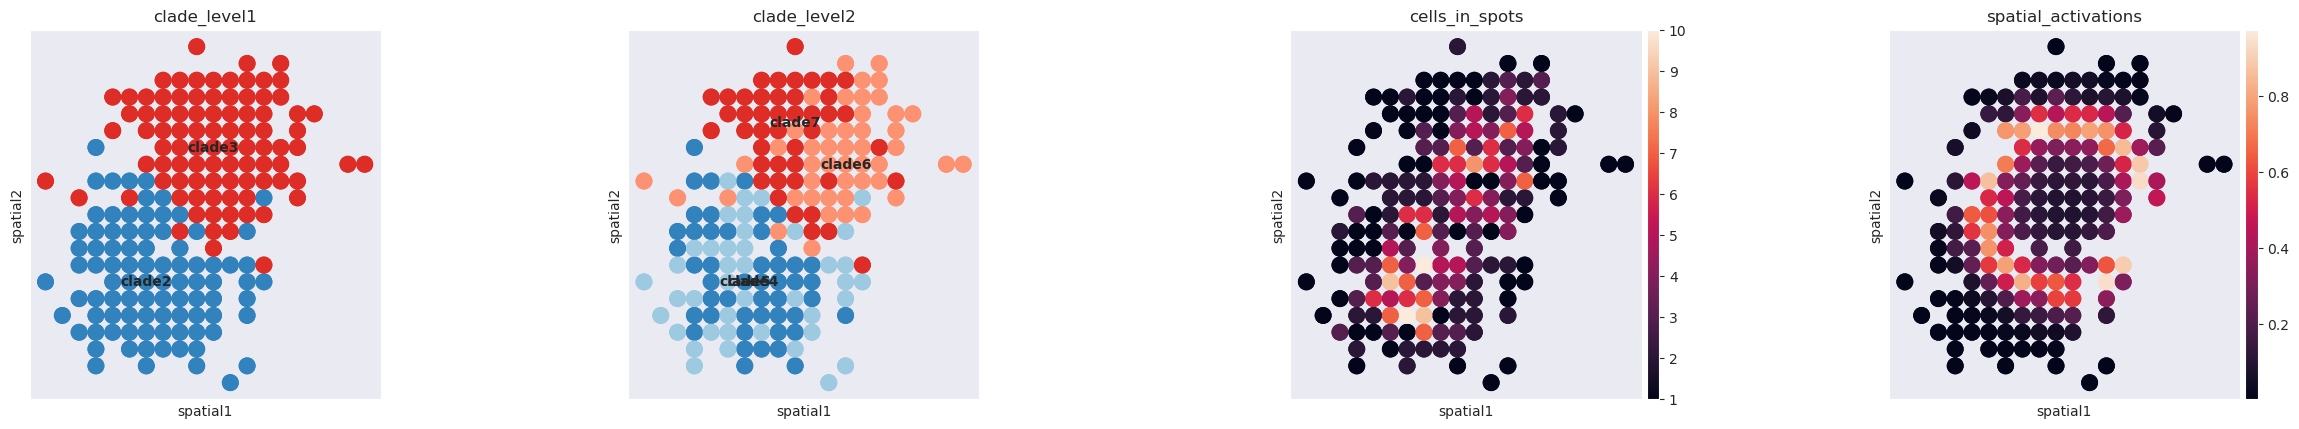

In [6]:
spatial_simulated_adata.uns['clade_level1_colors'] = ['#3182bd', '#de2d26',]
spatial_simulated_adata.uns['clade_level2_colors'] = ['#3182bd', '#9ecae1', '#fc9272', '#de2d26']
sc.pp.neighbors(spatial_simulated_adata)
sc.tl.umap(spatial_simulated_adata)
sc.pl.umap(spatial_simulated_adata, color=['clade_level1', 'clade_level2', 'cells_in_spots', 'spatial_activations'], legend_loc='on data')
sq.pl.spatial_scatter(spatial_simulated_adata, color=['clade_level1', 'clade_level2', 'cells_in_spots', 'spatial_activations'], 
                    library_id='puck1', shape=None, legend_loc='on data', size=500)

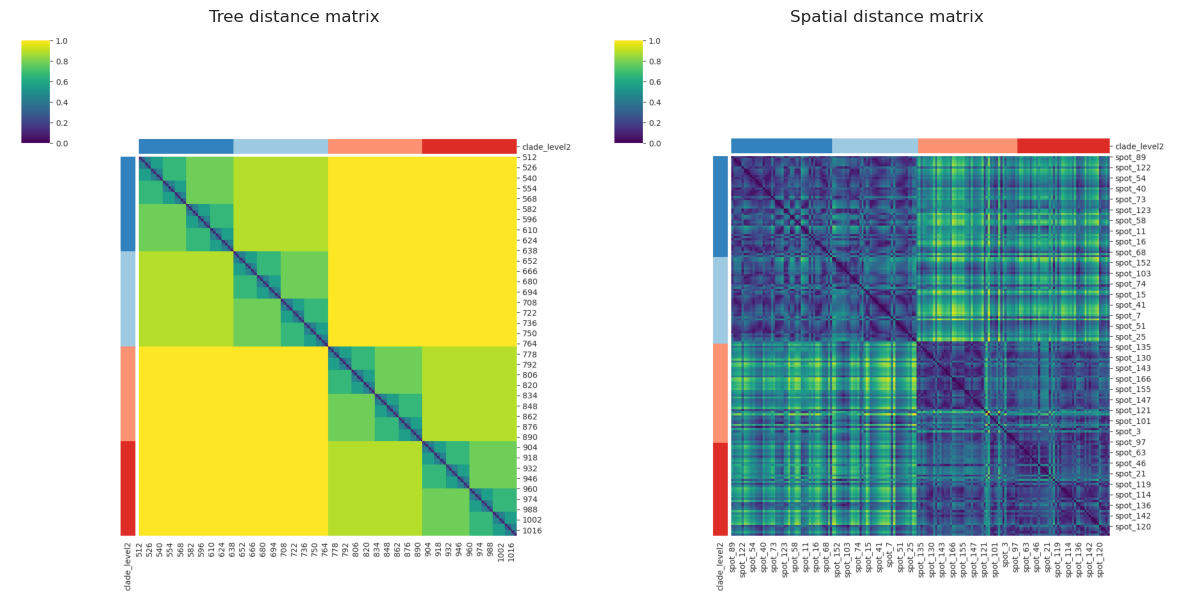

In [7]:
lut = dict(zip(["clade4", "clade5", "clade6", "clade7"], ss_simulated_adata.uns['clade_level2_colors']))
row_colors = ss_simulated_adata.obs['clade_level2'].map(lut)
g1 = sns.clustermap(tree_distance_matrix, row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors, cmap='viridis')

row_colors = spatial_simulated_adata.obs['clade_level2'].map(lut)
g2 = sns.clustermap(spatial_distance_matrix, row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors, cmap='viridis')

g1.figure.canvas.draw()
g2.figure.canvas.draw()

img1 = np.array(g1.figure.canvas.renderer.buffer_rgba())
img2 = np.array(g2.figure.canvas.renderer.buffer_rgba())

plt.close(g1.figure)
plt.close(g2.figure)

# Combine into one figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].set_title('Tree distance matrix')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Spatial distance matrix')
axes[1].axis('off')

plt.tight_layout()
plt.show()


/home/oskar/phd/phylospatial_mapping/notebooks/../src/spotr/utils.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'clade4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[subtree, 'clade'] = f'clade{node}'
/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


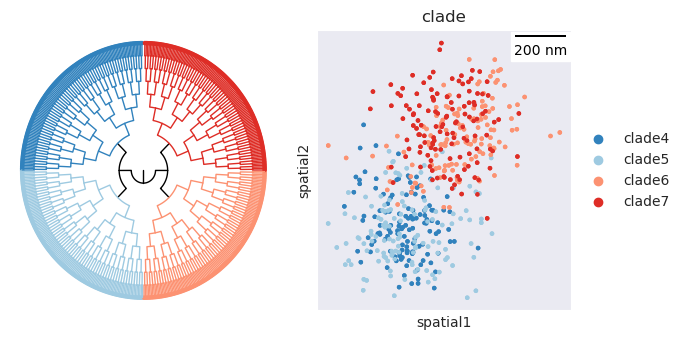

In [8]:
utils.plot_selection(simulated_tree, ss_simulated_adata, ['4', '5', '6', '7'], ['#3182bd', '#9ecae1', '#fc9272', '#de2d26'], orient=90)

## Benchmarking routine

### Testing scLVM + stLVM + scDOT

In [70]:
n_reps = 1
n_cells = 512
n_genes = 10
n_traits = 5

spatial_mode = 'main_clades'
expression_mode = 'tree'
rep = 0

ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, simulated_tree = utils.simulate_data(spatial_mode, expression_mode, seed=rep, n_cells=n_cells, n_genes=n_genes, n_traits=n_traits, obs_model='poisson')

Epoch 1673/2500:  67%|██████▋   | 1672/2500 [17:29:57<8:39:57, 37.68s/it, v_num=1, train_loss_step=4.49e+4, train_loss_epoch=4.52e+4]


In [78]:
ss_simulated_adata.layers["counts"] = ss_simulated_adata.X.copy()

sc_model = scvi_utils.fit_scLVM(ss_simulated_adata)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 300/300: 100%|██████████| 300/300 [00:08<00:00, 36.15it/s, v_num=1, train_loss_step=14.1, train_loss_epoch=14.2]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [00:08<00:00, 36.66it/s, v_num=1, train_loss_step=14.1, train_loss_epoch=14.2]


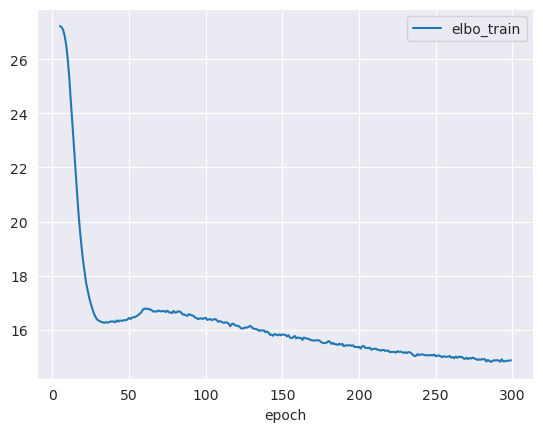

In [72]:
sc_model.history["elbo_train"].iloc[5:].plot()
plt.show()

In [79]:
spatial_simulated_adata.layers["counts"] = spatial_simulated_adata.X.copy()
st_model = scvi_utils.fit_stLVM(spatial_simulated_adata, sc_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/oskar/anaconda3/envs/phylospatial/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 2500/2500: 100%|██████████| 2500/2500 [00:48<00:00, 51.32it/s, v_num=1, train_loss_step=7.43e+3, train_loss_epoch=6.99e+3]

`Trainer.fit` stopped: `max_epochs=2500` reached.


Epoch 2500/2500: 100%|██████████| 2500/2500 [00:48<00:00, 51.06it/s, v_num=1, train_loss_step=7.43e+3, train_loss_epoch=6.99e+3]


               clade4    clade5        clade6        clade7
spot_68  9.298805e-07  0.999998  5.618387e-07  1.380672e-07
spot_95  6.558570e-07  0.999999  3.834120e-07  9.961549e-08
spot_94  6.894523e-07  0.999999  3.848283e-07  1.066914e-07
spot_93  8.087986e-07  0.999998  5.912385e-07  1.591743e-07
spot_91  8.360406e-07  0.999998  5.379600e-07  1.442715e-07
...               ...       ...           ...           ...
spot_22  5.218159e-07  0.999999  3.943755e-07  1.124992e-07
spot_20  8.577699e-07  0.999999  4.964076e-07  1.287655e-07
spot_18  1.201702e-06  0.999998  7.536817e-07  1.819366e-07
spot_34  8.533777e-07  0.999998  5.468565e-07  1.450959e-07
spot_0   1.616220e-06  0.999992  6.071333e-06  7.337677e-07

[138 rows x 4 columns]


<Axes: xlabel='epoch'>

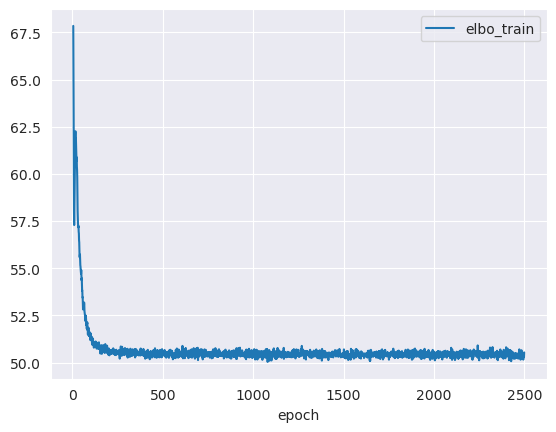

In [80]:
props = st_model.get_proportions()
print(props)
st_model.history["elbo_train"].iloc[5:].plot()

In [69]:
# scDOT
spatial_simulated_adata.uns["markers"] = ss_simulated_adata.uns['trait_signatures'].values
ss_simulated_adata.obsm["cell_type"] = ss_simulated_adata.obsm['trait_activations'].values / np.sum(ss_simulated_adata.obsm['trait_activations'].values, axis=1, keepdims=True)
scdot.train_scdot(ss_simulated_adata, spatial_simulated_adata)

(scDOT(
   (NNLS): NNLS()
   (OT): OptimalTransportLayer()
 ),
 array([[0.00864196, 0.00929861, 0.00929198, ..., 0.00839538, 0.00886748,
         0.00867445],
        [0.00730928, 0.0071642 , 0.00701911, ..., 0.00711575, 0.00706879,
         0.00715988],
        [0.00720168, 0.00733473, 0.00681395, ..., 0.00680294, 0.0067326 ,
         0.00697308],
        ...,
        [0.00684115, 0.00689185, 0.00681632, ..., 0.00704142, 0.00685212,
         0.00690552],
        [0.0072515 , 0.00685129, 0.00761376, ..., 0.00773504, 0.00786327,
         0.00763533],
        [0.00662158, 0.0068821 , 0.00658537, ..., 0.0068752 , 0.00654064,
         0.0066461 ]], shape=(136, 1024), dtype=float32))

### Main benchmarking script

In [10]:
spatial_modes = ['main_clades', 'subclades', 'main_and_subclades', 'unstructured']
expression_modes = ['tree', 'mix', 'external']
n_reps = 1
n_cells = 1024
n_genes = 500
n_traits = 5

clade_structure_scores = []

results_rows = []
for spatial_mode in spatial_modes:
    for expression_mode in expression_modes:
        for rep in range(n_reps):
            # Simulate data and store info, we may use it later for scoring other methods
            ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, simulated_tree = utils.simulate_data(spatial_mode, expression_mode, seed=rep, 
                                                                                                                                                                n_cells=n_cells, n_genes=n_genes, n_traits=n_traits)
            C_feature, C_tree, C_space, a, b = spotr.prepare_ot_inputs(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix.values, spatial_distance_matrix.values)
            true_structure_score_level0 = utils.structural_concordance(C_tree, C_space, true_couplings)
            level1_scores = []
            for clade in ss_simulated_adata.obs['clade_level1'].unique():
                clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
                true_structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, true_couplings[clade_idx], eps=1e-12)
                level1_scores.append(true_structure_score_level1)
            level2_scores = []
            for clade in ss_simulated_adata.obs['clade_level2'].unique():
                clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
                true_structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, true_couplings[clade_idx], eps=1e-12)
                level2_scores.append(true_structure_score_level2)
            clade_structure_scores.append({
                'spatial_mode': spatial_mode,
                'expression_mode': expression_mode,
                'rep': rep,
                'structure_level0': true_structure_score_level0,
                'structure_level1': level1_scores,
                'structure_level2': level2_scores
            })

            # Run Wasserstein OT
            coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, 0.01, T_sinkhorn=100, J_alt=0, 
                                        alpha=0.0, gamma0=None, uv0=None)
            utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
            mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
            structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
            level0_rmse = utils.compute_rmse(structure_score_level0, true_structure_score_level0)
            level1_rmse = []
            for i, clade in enumerate(ss_simulated_adata.obs['clade_level1'].unique()):
                clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
                structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
                level1_rmse.append(utils.compute_rmse(structure_score_level1, level1_scores[i]))
            level1_rmse = np.mean(level1_rmse)
            level2_rmse = []
            for i, clade in enumerate(ss_simulated_adata.obs['clade_level2'].unique()):
                clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
                structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
                level2_rmse.append(utils.compute_rmse(structure_score_level2, level2_scores[i]))
            level2_rmse = np.mean(level2_rmse)

            results_rows.append({
                'spatial_mode': spatial_mode,
                'expression_mode': expression_mode,
                'rep': rep,
                'method': 'Wasserstein OT',
                'pcorr': mean_pearson_corr,
                'structure_rmse_level0': level0_rmse,
                'structure_rmse_level1': level1_rmse,
                'structure_rmse_level2': level2_rmse
            })

            # Run GW OT
            coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, .01, T_sinkhorn=100, J_alt=20, alpha=1.0, gamma0=None, uv0=None)
            utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
            mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
            structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
            level0_rmse = utils.compute_rmse(structure_score_level0, true_structure_score_level0)
            level1_rmse = []
            for i, clade in enumerate(ss_simulated_adata.obs['clade_level1'].unique()):
                clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
                structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
                level1_rmse.append(utils.compute_rmse(structure_score_level1, level1_scores[i]))
            level1_rmse = np.mean(level1_rmse)
            level2_rmse = []
            for i, clade in enumerate(ss_simulated_adata.obs['clade_level2'].unique()):
                clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
                structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
                level2_rmse.append(utils.compute_rmse(structure_score_level2, level2_scores[i]))
            level2_rmse = np.mean(level2_rmse)

            results_rows.append({
                'spatial_mode': spatial_mode,
                'expression_mode': expression_mode,
                'rep': rep,
                'method': 'GW OT',
                'pcorr': mean_pearson_corr,
                'structure_rmse_level0': level0_rmse,
                'structure_rmse_level1': level1_rmse,
                'structure_rmse_level2': level2_rmse
            })

            # Run SpOTr
            cell_type_assignments = ss_simulated_adata.obsm['trait_activations'].values / np.sum(ss_simulated_adata.obsm['trait_activations'].values, axis=1, keepdims=True)
            cell_type_signatures = ss_simulated_adata.uns['trait_signatures'].values # should probably learn this...
            best_coupling_level, depth_results = spotr.run_spotr(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix,
                                                                        cell_type_assignments, cell_type_signatures,
                                                                        clade_columns=['clade_level0', 'clade_level1', 'clade_level2'], sigma=0.01)
            coupling = depth_results[best_coupling_level]['coupling']
            utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
            mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
            structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
            level0_rmse = utils.compute_rmse(structure_score_level0, true_structure_score_level0)
            level1_rmse = []
            for i, clade in enumerate(ss_simulated_adata.obs['clade_level1'].unique()):
                clade_idx = np.where(ss_simulated_adata.obs['clade_level1'] == clade)[0]
                structure_score_level1 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
                level1_rmse.append(utils.compute_rmse(structure_score_level1, level1_scores[i]))
            level1_rmse = np.mean(level1_rmse)
            level2_rmse = []
            for i, clade in enumerate(ss_simulated_adata.obs['clade_level2'].unique()):
                clade_idx = np.where(ss_simulated_adata.obs['clade_level2'] == clade)[0]
                structure_score_level2 = utils.structural_concordance(C_tree[clade_idx][:,clade_idx], C_space, coupling[clade_idx], eps=1e-12)
                level2_rmse.append(utils.compute_rmse(structure_score_level2, level2_scores[i]))
            level2_rmse = np.mean(level2_rmse)

            results_rows.append({
                'spatial_mode': spatial_mode,
                'expression_mode': expression_mode,
                'rep': rep,
                'method': 'SpOTr',
                'pcorr': mean_pearson_corr,
                'structure_rmse_level0': level0_rmse,
                'structure_rmse_level1': level1_rmse,
                'structure_rmse_level2': level2_rmse
            })

            # Add scDOT and DestVI
            # Should take as input ss_simulated_adata and spatial_simulated_adata

    results_df = pd.DataFrame(results_rows)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Only keep the five methods requested
methods_to_plot = ["correlation", "Wasserstein OT", "GW OT", "SpOTr-global"]
filtered_df = results_df[results_df['method'].isin(methods_to_plot)]

spatial_modes = filtered_df['spatial_mode'].unique()
n_spatial_modes = len(spatial_modes)

# List of metrics to plot as separate rows
metrics = [
    ("pcorr", "Mean Pearson correlation", (0, 1)),
    ("structure_rmse_level0", "RMSE (structure, level 0)", None),
    ("structure_rmse_level1", "RMSE (structure, level 1)", None),
    ("structure_rmse_level2", "RMSE (structure, level 2)", None),
]

n_metrics = len(metrics)

fig, axes = plt.subplots(
    n_metrics, n_spatial_modes,
    figsize=(6 * n_spatial_modes, 5 * n_metrics),
    sharey="row"
)

# Make sure axes is always 2D for consistent indexing
if n_metrics == 1:
    axes = [axes]
if n_spatial_modes == 1:
    axes = np.array(axes).reshape(n_metrics, 1)

for row, (metric, ylabel, ylim) in enumerate(metrics):
    for col, spatial_mode in enumerate(spatial_modes):
        ax = axes[row, col]
        data = filtered_df[filtered_df['spatial_mode'] == spatial_mode]
        sns.boxplot(
            data=data,
            x="expression_mode",
            y=metric,
            hue="method",
            hue_order=methods_to_plot,
            ax=ax
        )
        if row == 0:
            ax.set_title(f"Spatial mode: {spatial_mode}")
        if col == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("Expression mode")
        if ylim is not None:
            ax.set_ylim(*ylim)
        # Remove legends from all but last subplot in row
        if col != n_spatial_modes - 1:
            ax.legend_.remove()
        else:
            if row != 0:
                # Don't repeat legend for every metric, except first row
                ax.legend_.remove()

plt.tight_layout()
plt.show()